In [1]:
# Modules
import scipy as sp
import numpy as np
import scipy.integrate as integrate # for numerical integration
import matplotlib.pyplot as plt # for plotting
from astropy import units # manages units
%matplotlib inline

# Import constant with units from the astropy module
# https://docs.astropy.org/en/stable/constants/index.html#collections-of-constants-and-prior-versions
from astropy.constants import M_sun, m_p, sigma_T, sigma_sb, b_wien, G, c, h, k_B, L_sun, R_sun 

# Define matplotlibve style 
plt.style.use("defstyle.mplstyle")

# Ignore divide by zero errors (will generate NaNs but those will be replaced by zeros)
np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Formulas
Schwarschild Radius $$ R_s = \frac{2GM}{c^2}$$
Accretion rate at Eddington limit $$ \dot{M} = \frac{8\pi R_{in} m_p c}{\sigma_T}$$
Total luminosity $$L = \frac{1}{2} \frac{GM\dot M}{R_{in}}$$
The last two combined give the Eddington Luminosity: $$ L = \frac{4\pi G M m_p c}{\sigma_T}$$

In [2]:
# Tunable parameters 
m_dot = 1 # black hole accretion rate as fraction of Eddington accretion rate
M = 4e6 * M_sun # mass of black hole as multiple of solar mass
print("M:", M)

# Useful values
R_s = 2*G*M/(c**2) # Schwarschild radius 
R_in = 3*R_s # innermost stable orbit (approximate)
print("R_in:", R_in)

M_dot_edd = 8*np.pi*R_in*m_p*c/sigma_T # accretion rate at Eddington limit
M_dot = m_dot*M_dot_edd # black hole accretion rate for chosen value of m_dot
print("M_dot:", M_dot)

# Temperature scale parameter for temperature distribution of accretion disk
T_s = (3*G*M*M_dot/(8*np.pi*sigma_sb*(R_in**3)))**(1./4.)
print("T_s:", T_s.to("K"))

# Predicted Luminosities (should be the same, as L_edd assumes L_tot and M_dot_edd formula)
L_edd = 4*np.pi*G*M*m_p*c/sigma_T # Eddington luminosity
L_tot = 0.5*G*M*M_dot/R_in

print("L_tot:", L_tot)
print("L_edd:", L_edd.to("erg/s"))

M: 7.953639482792203e+36 kg
R_in: 35439000913.20299 m
M_dot: 6.713633485534001e+21 kg / s
T_s: 640750.0158617214 K
L_tot: 5.028260719387164e+37 kg m2 / s3
L_edd: 5.0282607193871634e+44 erg / s


In [3]:
# Values for testing frequency ranges
lam_wien_Ts = b_wien/T_s # Wien's wavelength for T_s
nu_max_Ts = 5.87893e10/(units.s*units.K) * T_s # Wien's law in terms of frequency (peak is different!) From https://pubs.acs.org/doi/pdf/10.1021/ed400113z
nu_Ts = k_B*T_s/h # Frequency at which h*nu/k_b*T_s = 1

# In photon energy:
hnu_wien = lam_wien_Ts.to("eV", equivalencies=units.spectral())
hnu_max = nu_max_Ts.to("eV", equivalencies=units.spectral())
hnu_Ts = nu_Ts.to("eV", equivalencies=units.spectral())

print(hnu_wien, hnu_max, hnu_Ts)

274.15158384193603 eV 155.78747933145922 eV 55.21556424405263 eV


## Effective Temperature
$$ T_{eff}(r) = T_s \sqrt[^4]{(r^{-3} - r^{-\frac{7}{2}})} $$
where
$$ T_s = \sqrt[^4]{\frac{GM\dot M }{8 \pi \sigma R_{in}^2}}$$

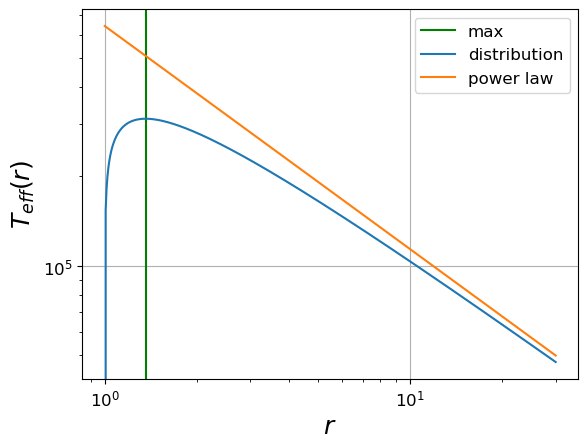

In [4]:
# Temperature distribution with adimensional radius r = R/R_in
from EUV_flux import T_eff

r_lim = 30 # Radius limit

r = np.logspace(0, np.log10(r_lim), 500) # plot x values

plt.axvline(49/36, color="green", label="max") # Line at expected max value
plt.loglog(r, T_eff(r, T_s), label="distribution")
plt.loglog(r, T_s*r**(-3/4), label="power law") # power law approximation valid for r >> 1

# plot formatting
plt.xlabel(r"$r$")
plt.ylabel(r"$T_{eff}(r)$")
plt.legend()
plt.grid()

## Planck Spectrum
$$ B_{\nu}(T) = \frac{2h\nu^3}{c^2}\frac{1}{\exp{\frac{h\nu}{k_B T}} - 1}$$

Is the power emitted per unit area of a blackbody at temperature T, into a unit solid angle, in the frequency interval ν to ν +dν.

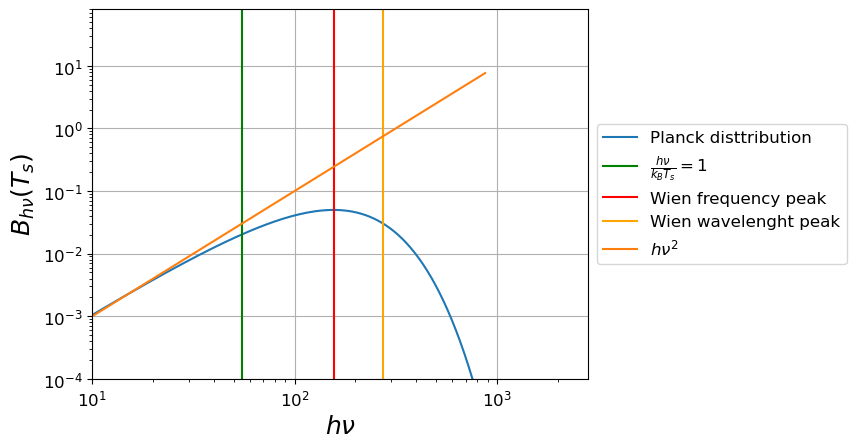

In [5]:
from EUV_flux import planck_law
hnu = hnu_Ts*np.logspace(-9, 1.2, 500) # plot x values

# Plot to test
plt.plot(hnu.to("eV"), planck_law(hnu/h, T_s).to("W*s/m2"), label="Planck disttribution")
plt.axvline(hnu_Ts.to("eV").value, color="green", label=r"$\frac{h\nu}{k_B T_s} = 1$")
plt.axvline(hnu_max.to("eV").value, color="red", label="Wien frequency peak")
plt.axvline(hnu_wien.to("eV").value, color="orange", label="Wien wavelenght peak")
plt.plot(hnu.to("eV"), 1e-5*hnu.to("eV")**2, label = r"$h\nu ^2$")

# Plot formatting
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$h\nu$")
plt.ylabel(r"$B_{h\nu}(T_s)$")
plt.xlim(left=10)
plt.ylim(bottom=1e-4)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

### Test Planck Spectrum:
Integrating the whole spectrum with the parameters for the sun should give the solar luminosity $L_{sun}$.
The integration limits can be chosen to be $h\nu = 0$ (or a number very close) and a value much larger than $k_B T_{eff}$, where $T_{eff}$ is the effective temperature of the Sun, in this case $h\nu = 20 k_B T_{eff}$ was chosen, which is far into the exponential tail of the distribution.


Calculated luminosity: 3.849177411454034e+26 W
Using Stefan-Boltzmann Law: 3.84925746826915e+26 W
Astropy Solar Luminosity 3.828e+26 W


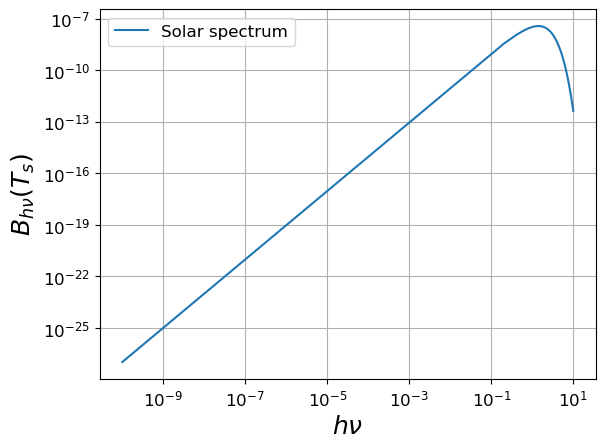

In [6]:
T_eff_sun = 5780 * units.K
nu = (np.linspace(1e-10, (20*k_B*T_eff_sun).to("eV").value) * units.eV)/h 
solar_spectrum = planck_law(nu, T_eff_sun) # Units of eV

# Plot spectrum for visual check
plt.loglog((h * nu).to("eV"), solar_spectrum.to("W*s/m2"), label="Solar spectrum")

# Plot formatting
plt.xlabel(r"$h\nu$")
plt.ylabel(r"$B_{h\nu}(T_s)$")
plt.legend()
plt.grid()

# Factor of pi becaouse of integration over solid angle, surface area because of integration over surface area
integral = np.pi*integrate.trapezoid(solar_spectrum.to("W*s/m2").value, nu.to("Hz").value) * units.W / (units.m)**2 
surface_area = 4*np.pi*R_sun**2 
L_int = surface_area * integral

print("Calculated luminosity:", L_int)
print("Using Stefan-Boltzmann Law:", surface_area*sigma_sb*(T_eff_sun**4))
print("Astropy Solar Luminosity", L_sun*1)


### Integral
$$\int_{R_{in}}^{\infty} 2\pi^2\, R \, B_{\nu}(T(R)) \,dR = 2\pi^2 R_{in}^2 \int_{1}^{\infty} r \, B_{\nu}(T(r)) \,dr$$

Note: one $\pi$ factor comes from integrating over the solid angle

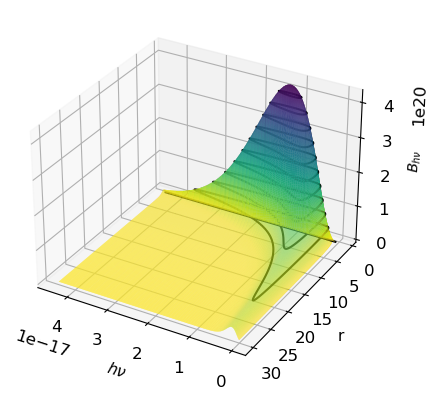

In [7]:
# Plot the integrand
r_lim = 30 # Plot radius limit
x = nu_Ts*np.logspace(np.log10(0 + 1e-5), np.log10(5), 301) # Limits are chosen to shouw the interesting section of the plot
y = np.logspace(start=0, stop=np.log10(r_lim), num=1000)
nu, r = np.meshgrid(x, y)

# Factor of 2 to count both sides of the disk
integrand = lambda nu, r: 4*(np.pi)**2*(R_in**2)*r*planck_law(nu, T_eff(r, T_s))
I = integrand(nu, r).to("W*s")

# Initialise 3D plot
ax = plt.axes(projection='3d')
# Plot the function of two variables
ax.plot_surface((h*nu), r, I, rstride=1, cstride=1,cmap='viridis_r', edgecolor = 'none')

# Add contour lines
ax.contour((h*nu).value, r, I.value, 10, colors = "k", linestyles="solid")

# Plot formatting
ax.set_xlabel(r'$h\nu$', fontsize = 11)
ax.set_ylabel('r', fontsize = 11)
ax.set_zlabel(r'$B_{h\nu}$', fontsize = 10)

ax.azim = 120
ax.dist = 10
ax.elev = 30

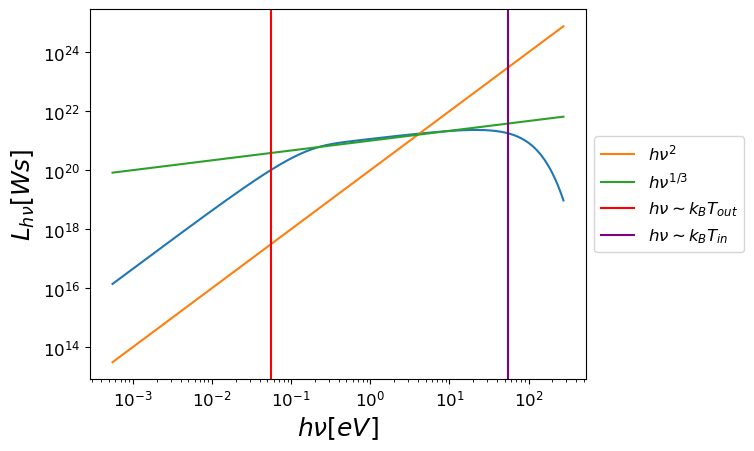

In [22]:
r_lim = 1e4 # Plot radius limit
x = nu_Ts*np.logspace(np.log10(0 + 1e-5), np.log10(5), 3000) # Limits are chosen to shouw the interesting section of the plot
y = np.logspace(np.log10(1 + 1e-5), np.log10(r_lim), 300)#np.logspace(np.log10(1 + 1e-5), np.log10(r_lim), 300)
nu, r = np.meshgrid(x, y)

I = integrand(nu, r).to("W*s")

hnu = (h*x).to("eV")
nan_location = np.isnan(I) 
I[nan_location] = 0 # remove NaN values

res = [] # will store integration result
for slice in I.value.transpose():
    integral = integrate.trapezoid(slice, y)
    res.append(integral)

luminosity = np.array(res) * units.W * units.s

plt.loglog(hnu, luminosity.to("W*s"))

plt.plot(hnu, (1e20*hnu**(2)), label = r"$h\nu^{2}$")
plt.plot(hnu, (1e21*hnu**(1/3)), label = r"$h\nu^{1/3}$")

plt.axvline((k_B*T_eff(r_lim, T_s)).to("eV").value, color="red", label=r"$h\nu \sim k_B T_{out}$")
plt.axvline((k_B*T_s).to("eV").value, color="purple", label=r"$h\nu \sim k_B T_{in}$")

plt.xlabel(r"$h\nu [eV]$")
plt.ylabel(r"$L_{h\nu}[Ws]$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.xlim(1e-5, 3e2)

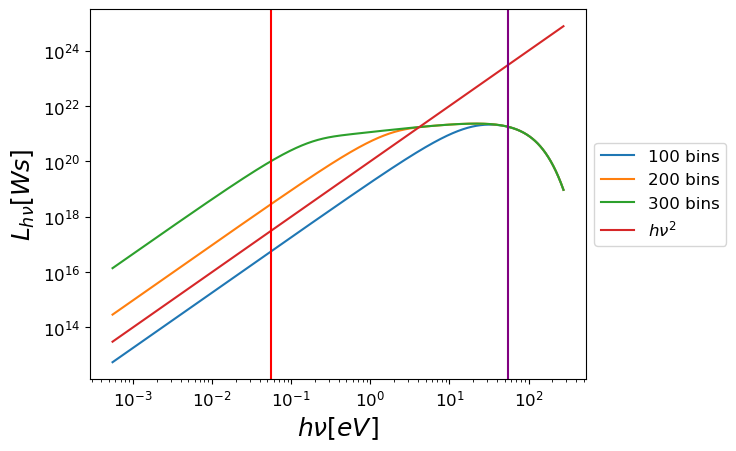

In [23]:
for i, n in enumerate([100, 200, 300]):
    res = [] # will store integration result
    for slice in I.value.transpose():
        integral = integrate.trapezoid(slice[:n], y[:n])
        res.append(integral)

    lum = np.array(res) * units.W * units.s

    plt.plot(hnu.to("eV"), lum.to("W*s"), label = str(n) + " bins")

plt.xlabel(r"$h\nu [eV]$")
plt.ylabel(r"$L_{h\nu}[Ws]$")
plt.loglog(hnu, (1e20*hnu**(2)), label = r"$h\nu^{2}$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.axvline((k_B*T_eff(r_lim, T_s)).to("eV").value, color="red", label=r"$h\nu \sim k_B T_{out}$")
plt.axvline((k_B*T_s).to("eV").value, color="purple", label=r"$h\nu \sim k_B T_{in}$")


In [10]:
# Check: find total luminosity
nu = hnu / h
L = integrate.trapezoid(luminosity.to("W*s").value, nu.to("Hz").value) * units.W
print("Predicted total luminosity", L_tot.to("W"))
print("Calculated total luminosity", L)
print("Eddington luminosity", L_edd.to("W"))

Predicted total luminosity 5.028260719387164e+37 W
Calculated total luminosity 5.019392122863461e+37 W
Eddington luminosity 5.028260719387164e+37 W


To find the

In [14]:
# Calculate EUV flux


# Find left and right indices for integration
l_lim_index = np.min(np.where((h*nu).to("eV").value > 13.6))
r_lim_index = np.max(np.where((h*nu).to("eV").value < 200))

trim_luminosity = luminosity[l_lim_index:r_lim_index]
trim_nu = nu[l_lim_index:r_lim_index]

print((h*trim_nu).to("eV")[0], (h*trim_nu).to("eV")[-1])

L_euv = integrate.trapezoid(trim_luminosity.to("W*s").value, trim_nu.to("Hz").value) * units.W
print("Calculated luminosity", L_euv)

13.602913341643436 eV 198.84275032692028 eV
Calculated luminosity 4.354987615737608e+37 W
